In [21]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, GlobalAveragePooling2D, Dense, Dropout,
                                     BatchNormalization, Activation, add, MaxPooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Set up parameters
input_shape = (224, 224, 3)       # Input dimensions expected by EfficientNet
batch_size = 32
initial_epochs = 5               # Epochs for initial training (head layers)
fine_tune_epochs = 5             # Epochs for fine-tuning the backbone layers
train_dir = '/kaggle/input/deep-learning-project/real_vs_fake/real-vs-fake/train'      # Replace with your train directory path
val_dir   = '/kaggle/input/deep-learning-project/real_vs_fake/real-vs-fake/train'        # Replace with your validation directory path


In [13]:
# Data generators using EfficientNet preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.15
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Create data generators for train and validation directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)


Found 100000 images belonging to 2 classes.
Found 100000 images belonging to 2 classes.


In [14]:
# Load EfficientNetB0 as the backbone (without the top classification layers)
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze the base model for the initial training phase


In [15]:
def residual_block(x, filters, kernel_size=3, stride=1):
    """
    A custom residual block with two convolution layers and a skip connection.
    """
    shortcut = x

    # First convolution block
    x = Conv2D(filters, kernel_size, padding='same', strides=stride)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolution block
    x = Conv2D(filters, kernel_size, padding='same', strides=1)(x)
    x = BatchNormalization()(x)
    
    # Adjust the shortcut if dimensions differ
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = Conv2D(filters, kernel_size=1, padding='same', strides=stride)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # Combine and activate
    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x


In [16]:
# Create the model head on top of the EfficientNet backbone
x = base_model.output
x = residual_block(x, 64)               # First residual block
x = MaxPooling2D(pool_size=(2, 2))(x)     # Pooling to reduce spatial dimensions
x = residual_block(x, 128)              # Second residual block
x = MaxPooling2D(pool_size=(2, 2))(x)
x = GlobalAveragePooling2D()(x)         # Global pooling to flatten feature maps
x = Dense(256, activation='relu')(x)      # Dense layer with 256 neurons
x = Dropout(0.5)(x)                     # Dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Final output for binary classification

# Define the complete model
model = Model(inputs=base_model.input, outputs=output)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_1[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ normalization_1[0][0]  │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 32)       │            288 │ block1a_se_reduce[0][… │
│ (Conv2D)             

 Total params: 5,171,172 (19.73 MB)

 Trainable params: 1,120,449 (4.27 MB)

 Non-trainable params: 4,050,723 (15.45 MB)

In [17]:
# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Define callbacks: EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
]


In [18]:
history = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=val_generator,
    callbacks=callbacks
)


3124/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.5229 - auc: 0.5289 - loss: 0.7123
Epoch 1: val_loss improved from inf to 1.10339, saving model to best_model.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1952s 613ms/step - accuracy: 0.5229 - auc: 0.5289 - loss: 0.7123 - val_accuracy: 0.5000 - val_auc: 0.5990 - val_loss: 1.1034 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.


In [22]:
# Unfreeze the last portion of the base model for fine-tuning
base_model.trainable = True
# Freeze all layers except the last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

print("Starting fine-tuning...")
history_finetune = model.fit(
    train_generator,
    epochs=fine_tune_epochs,
    validation_data=val_generator,
    callbacks=callbacks
)


Starting fine-tuning...
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.5303 - auc: 0.5425 - loss: 0.6930
Epoch 1: val_loss improved from 1.10339 to 0.68395, saving model to best_model.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1559s 486ms/step - accuracy: 0.5303 - auc: 0.5425 - loss: 0.6930 - val_accuracy: 0.5420 - val_auc: 0.6358 - val_loss: 0.6839 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 1.


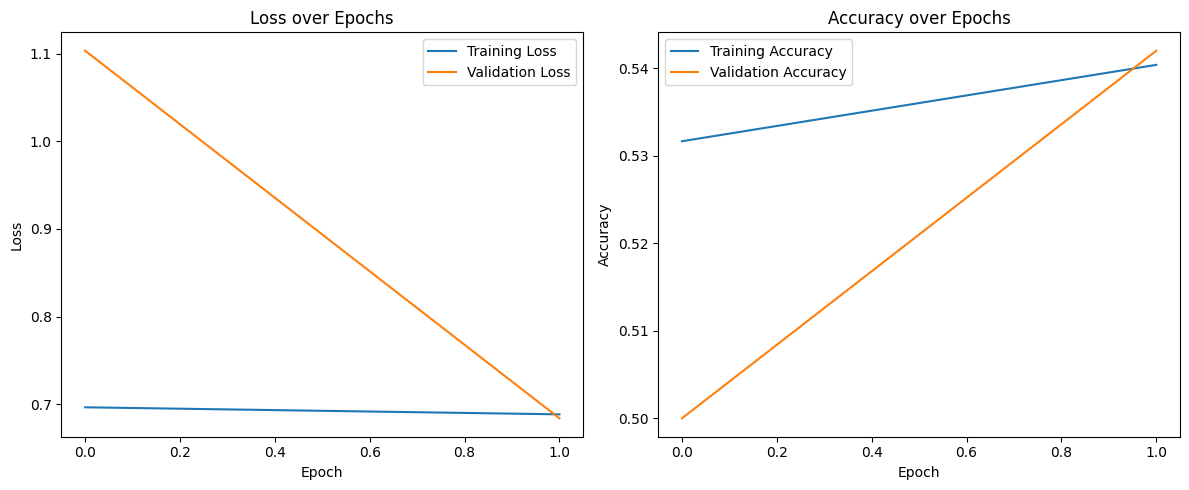

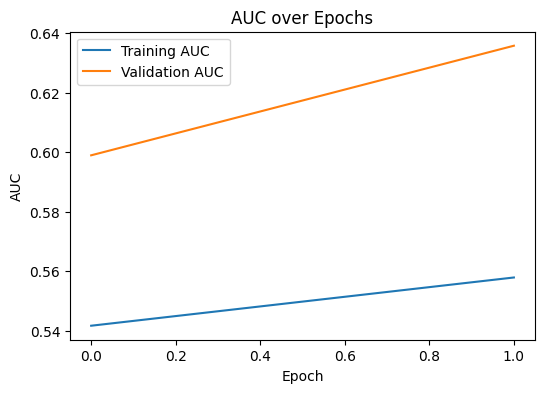

In [23]:
# Combine history from initial training and fine-tuning for plotting
acc = history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history.history['loss'] + history_finetune.history['loss']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss']
auc = history.history['auc'] + history_finetune.history['auc']
val_auc = history.history['val_auc'] + history_finetune.history['val_auc']

total_epochs = range(len(acc))

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(total_epochs, loss, label='Training Loss')
plt.plot(total_epochs, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(total_epochs, acc, label='Training Accuracy')
plt.plot(total_epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot AUC
plt.figure(figsize=(6, 4))
plt.plot(total_epochs, auc, label='Training AUC')
plt.plot(total_epochs, val_auc, label='Validation AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()


In [24]:
val_loss_result, val_acc_result, val_auc_result = model.evaluate(val_generator, verbose=1)
print("Validation Loss: {:.4f}".format(val_loss_result))
print("Validation Accuracy: {:.4f}".format(val_acc_result))
print("Validation AUC: {:.4f}".format(val_auc_result))


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 215s 69ms/step - accuracy: 0.5437 - auc: 0.6339 - loss: 0.6836
Validation Loss: 0.6839
Validation Accuracy: 0.5420
Validation AUC: 0.6358


Code 2

In [1]:
# Import libraries and set parameters
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD


# Set up parameters
input_shape = (224, 224, 3)  # Input dimensions for ResNet50
batch_size = 8
epochs = 12   # Total number of epochs for training

# Directories for training and validation data (adjust these paths as needed)
train_dir = '/kaggle/input/deep-learning-project/real_vs_fake/real-vs-fake/train'
val_dir   = '/kaggle/input/deep-learning-project/real_vs_fake/real-vs-fake/valid'

In [2]:
# Create data generators using ResNet50 preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2]   
)


val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [3]:
# Build the deep fake detection model with ResNet50 as the backbone and add regularization
# Load the pre-trained ResNet50 model without the top classification layers.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze the backbone layers during initial training

# Build the custom classification head on top of the frozen base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling to reduce spatial dimensions

# Add a Dense layer with 256 neurons, using L2 regularization to help prevent overfitting
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)

# Apply Dropout 
x = Dropout(0.3)(x)

# Final output layer for binary classification
output = Dense(1, activation='sigmoid')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=output)
model.summary()


I0000 00:00:1744743557.456082      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [4]:
# Compile and train the model, with callbacks for early stopping, model saving, and learning rate reduction.
model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_model_resnet50.keras", monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
]

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744743574.635882     106 service.cc:148] XLA service 0x7855a804dab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744743574.637100     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744743576.031189     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


    3/12500 ━━━━━━━━━━━━━━━━━━━━ 15:51 76ms/step - accuracy: 0.5278 - auc: 0.3982 - loss: 1.4099  

I0000 00:00:1744743579.638952     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12499/12500 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6907 - auc: 0.7573 - loss: 1.0330
Epoch 1: val_loss improved from inf to 0.88116, saving model to best_model_resnet50.keras
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 1821s 144ms/step - accuracy: 0.6907 - auc: 0.7573 - loss: 1.0329 - val_accuracy: 0.7896 - val_auc: 0.8747 - val_loss: 0.8812 - learning_rate: 1.0000e-04
Epoch 2/12
12499/12500 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7828 - auc: 0.8630 - loss: 0.8914
Epoch 2: val_loss improved from 0.88116 to 0.83179, saving model to best_model_resnet50.keras
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 1581s 126ms/step - accuracy: 0.7828 - auc: 0.8630 - loss: 0.8914 - val_accuracy: 0.8096 - val_auc: 0.9069 - val_loss: 0.8318 - learning_rate: 1.0000e-04
Epoch 3/12
12499/12500 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8077 - auc: 0.8884 - loss: 0.8306
Epoch 3: val_loss improved from 0.83179 to 0.77676, saving model to best_model_resnet50.keras
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 1575s 126m

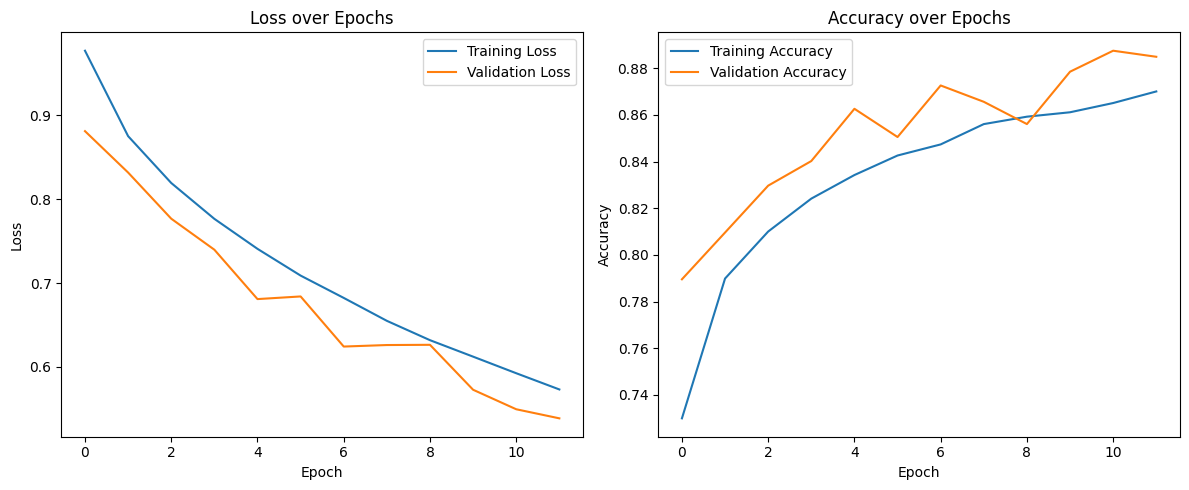

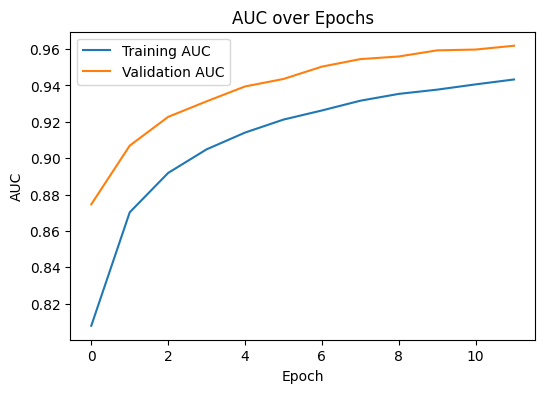

In [5]:
# Plot the training and validation loss, accuracy, and AUC over epochs

# Retrieve training history details
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
auc = history.history['auc']
val_auc = history.history['val_auc']

epochs_range = range(len(acc))

# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot AUC
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()


In [6]:
# Evaluate the model on the validation set and save the trained model

val_loss_result, val_acc_result, val_auc_result = model.evaluate(val_generator, verbose=1)
print("Validation Loss: {:.4f}".format(val_loss_result))
print("Validation Accuracy: {:.4f}".format(val_acc_result))
print("Validation AUC: {:.4f}".format(val_auc_result))

# Save the final trained model to disk
model.save("final_deep_fake_detection_resnet50.h5")
print("Final model saved as final_deep_fake_detection_resnet50.h5")

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - accuracy: 0.8846 - auc: 0.9610 - loss: 0.5430
Validation Loss: 0.5387
Validation Accuracy: 0.8849
Validation AUC: 0.9619
Final model saved as final_deep_fake_detection_resnet50.h5


# CODE 3

### Import Main Libraries

In [1]:
# Import Main Libraries
import numpy as np      
import pandas as pd     
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from keras.preprocessing import image
from sklearn import metrics

tf.keras.backend.clear_session()  

### Data Loading and Directory Setup

In [2]:
# Define the main path and subdirectories for training, validation, and test sets
main_path = '/kaggle/input/deep-learning-project/real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

# Print subfolder names to verify structure 
print("Train_dir Subfolders:", os.listdir(train_dir))
print("Valid_dir Subfolders:", os.listdir(valid_dir))
print("Test_dir Subfolders:", os.listdir(test_dir))

Train_dir Subfolders: ['fake', 'real']
Valid_dir Subfolders: ['fake', 'real']
Test_dir Subfolders: ['fake', 'real']


### Exploratory Data Analysis (EDA)

In [3]:
# Create a dataframe that stores folder names, image paths, and labels
images_df = {
    "folder": [],
    "image_path": [],
    "label": []
}

for folder in os.listdir(main_path):  
    for label in os.listdir(os.path.join(main_path, folder)):  
        for img in glob.glob(os.path.join(main_path, folder, label, "*.jpg")):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

images_df = pd.DataFrame(images_df)
images_df  # Display the dataframe

folder                                         image_path label
0       valid  /kaggle/input/deep-learning-project/real_vs_fa...  fake
1       valid  /kaggle/input/deep-learning-project/real_vs_fa...  fake
2       valid  /kaggle/input/deep-learning-project/real_vs_fa...  fake
3       valid  /kaggle/input/deep-learning-project/real_vs_fa...  fake
4       valid  /kaggle/input/deep-learning-project/real_vs_fa...  fake
...       ...                                                ...   ...
139995  train  /kaggle/input/deep-learning-project/real_vs_fa...  real
139996  train  /kaggle/input/deep-learning-project/real_vs_fa...  real
139997  train  /kaggle/input/deep-learning-project/real_vs_fa...  real
139998  train  /kaggle/input/deep-learning-project/real_vs_fa...  real
139999  train  /kaggle/input/deep-learning-project/real_vs_fa...  real

[140000 rows x 3 columns]

### Labels Distribution

In [4]:
# Group images by folder for each label to check distribution
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

print("Real Images Count:\n", real_grouped_df.size())
print("Fake Images Count:\n", fake_grouped_df.size())

Real Images Count:
 folder
test     10000
train    50000
valid    10000
dtype: int64
Fake Images Count:
 folder
test     10000
train    50000
valid    10000
dtype: int64


### Data Augmentation Setup

In [5]:
# Set up ImageDataGenerators for training (with augmentation) and for validation/testing (rescaling only)
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True
)

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

### Data Flow Setup for Training, Validation, and Testing

In [6]:
# Create training, validation, and test datasets using flow_from_directory
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

# For test data, disable shuffling so that predictions match the ground truth
test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False  
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


### Helper Function for Visualizing Images

In [7]:
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img[i])
        plt.axis('off')
        plt.title("Fake" if label[i] == 0 else "Real")

### Visualize a Batch of Training Images

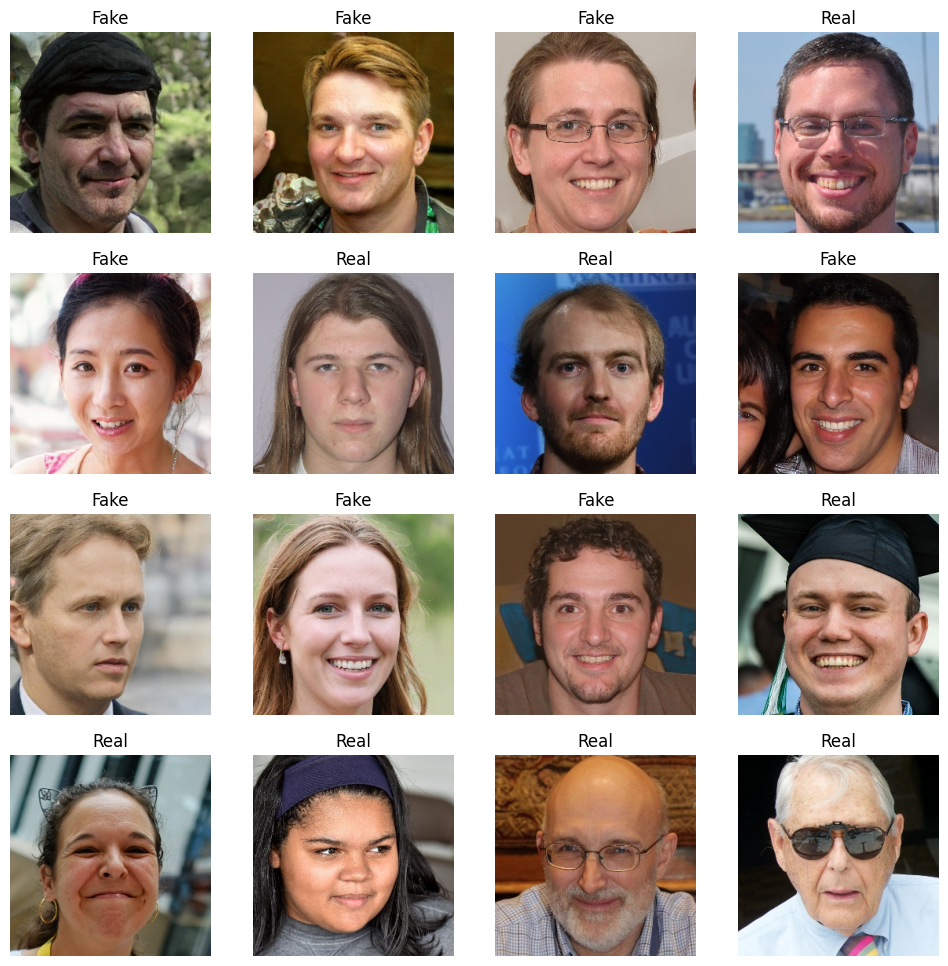

In [8]:
# Get and visualize a batch of training images
img_batch, lbl_batch = next(train_ds)
plot_images(img_batch, lbl_batch)

### Check Image Scaling and Input Shape

In [9]:
# Check scaled pixel values from a sample image
for img, label in train_ds:
    print("Example image values:", img[0])
    print("Example label:", label[0])
    break

# Check the shape of a batch
for img, label in train_ds:
    print("Image batch shape:", img.shape)  # Expected: (batch_size, 256, 256, 3)
    print("Label batch shape:", label.shape)
    break

# Display class indices mapping (e.g., {'fake': 0, 'real': 1})
print("Class indices:", train_ds.class_indices)

Example image values: [[[0.0509804  0.09803922 0.05882353]
  [0.04705883 0.09411766 0.05490196]
  [0.04313726 0.08235294 0.04705883]
  ...
  [0.03921569 0.05882353 0.03137255]
  [0.03921569 0.0627451  0.02352941]
  [0.04313726 0.06666667 0.02745098]]

 [[0.05490196 0.10196079 0.0627451 ]
  [0.05882353 0.10588236 0.06666667]
  [0.05490196 0.09411766 0.05882353]
  ...
  [0.03921569 0.05882353 0.03137255]
  [0.03921569 0.0627451  0.02352941]
  [0.03921569 0.0627451  0.02352941]]

 [[0.0627451  0.10196079 0.06666667]
  [0.07058824 0.10980393 0.07450981]
  [0.05882353 0.09803922 0.05490196]
  ...
  [0.03921569 0.0627451  0.02352941]
  [0.03529412 0.06666667 0.02352941]
  [0.03529412 0.06666667 0.02352941]]

 ...

 [[0.00784314 0.01568628 0.01176471]
  [0.00784314 0.01568628 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.5529412  0.5647059  0.62352943]
  [0.45882356 0.47058827 0.5294118 ]
  [0.5137255  0.5254902  0.5921569 ]]

 [[0.00784314 0.01568628 0.01176471]
  [0.00784314 0

### Build the CNN Model Using ResNet50

In [10]:
# Define input shape
input_shape = (256, 256, 3)

# Build the model using ResNet50 as the backbone
def get_model(input_shape):
    inp = tf.keras.Input(shape=input_shape)
    resnet = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary classification
    model = tf.keras.Model(resnet.input, output)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

model_ft = get_model(input_shape)
model_ft.summary()
# tf.keras.utils.plot_model(model_ft, to_file='model_plot.png', show_shapes=True)

I0000 00:00:1744763401.200374      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,639,361 (93.99 MB)

 Trainable params: 24,585,217 (93.79 MB)

 Non-trainable params: 54,144 (211.50 KB)

### Define Training Callbacks

In [11]:
# Set up callbacks to save the best model and adjust training dynamically
checkpoint_filepath = "model_cp.weights.h5"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3
)

### Train the ResNet50 Model

In [12]:
# Train the model using the training and validation datasets
history_ft = model_ft.fit(
    train_ds,
    epochs=1,
    validation_data=valid_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744763475.609770     118 service.cc:148] XLA service 0x7d86780039c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744763475.611030     118 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744763480.252241     118 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-16 00:31:27.887714: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,1024,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,2048,8,8]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 s

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 983s 573ms/step - accuracy: 0.8634 - loss: 0.3192 - val_accuracy: 0.6975 - val_loss: 1.2810 - learning_rate: 0.0010


### Plot Training History

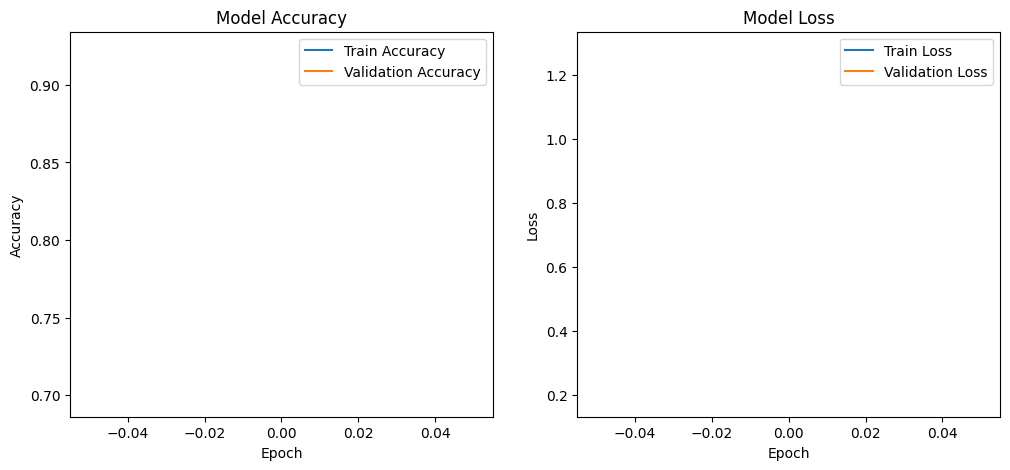

In [13]:
# Plot training vs. validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_ft.history['accuracy'], label='Train Accuracy')
plt.plot(history_ft.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_ft.history['loss'], label='Train Loss')
plt.plot(history_ft.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

### Evaluate the Model on the Test Set (Before Restoration)

In [14]:
# Evaluate the current (possibly overfitted) model on the test set
test_loss, test_acc = model_ft.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 147s 471ms/step - accuracy: 0.4918 - loss: 2.2172
Test Loss: 1.2986575365066528
Test Accuracy: 0.6983000040054321


### Restore Best Weights and Re-Evaluate

In [15]:
# Create a new model instance and load the best weights saved during training
model = get_model(input_shape)
model.load_weights('/kaggle/working/model_cp.weights.h5')  

# Evaluate the restored model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss after restoring best weights:", test_loss)
print("Test Accuracy after restoring best weights:", test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 438 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 213ms/step - accuracy: 0.4918 - loss: 2.2172
Test Loss after restoring best weights: 1.2986575365066528
Test Accuracy after restoring best weights: 0.6983000040054321


### Qualitative Results: Real Image Prediction

In [16]:
# Load a sample real image and predict its class
test_image = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/deep-learning-project/real_vs_fake/real-vs-fake/test/real/00170.jpg',
    target_size=(256, 256, 3)
)
plt.imshow(test_image)
plt.axis('off')

test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image_arr, axis=0)
test_image_arr = test_image_arr / 255.

result = model.predict(test_image_arr)
plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Text(0.5, 1.0, 'This image is 0.02% Fake and 99.98% Real.')

### Qualitative Results: Fake Image Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Text(0.5, 1.0, 'This image is 54.50% Fake and 45.50% Real.')

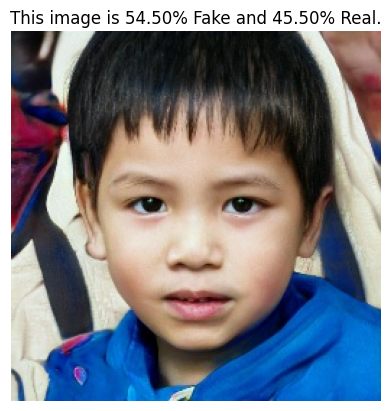

In [17]:
# Load a sample fake image and predict its class
test_image = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/deep-learning-project/real_vs_fake/real-vs-fake/test/fake/02XAKN4F4U.jpg',
    target_size=(256, 256, 3)
)
plt.imshow(test_image)
plt.axis('off')

test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image_arr, axis=0)
test_image_arr = test_image_arr / 255.

result = model.predict(test_image_arr)
plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

### Quantitative Results: Confusion Matrix and ROC Curve

313/313 ━━━━━━━━━━━━━━━━━━━━ 75s 226ms/step


Test Accuracy (from confusion matrix): 0.6983


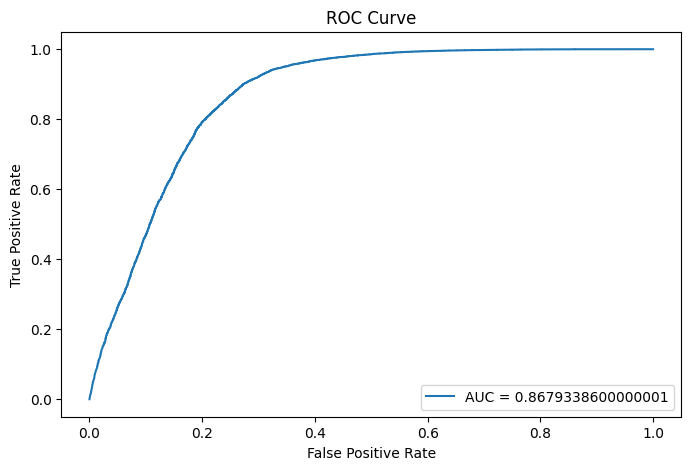

In [18]:
# Generate predictions for the test set and evaluate performance
predicted_labels = model.predict(test_ds)
true_labels = test_ds.classes

# Plot the confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()),
            annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix")
plt.show()

print("Test Accuracy (from confusion matrix):", metrics.accuracy_score(true_labels, predicted_labels.round()))

# Compute and plot the ROC curve
fpr, tpr, _ = metrics.roc_curve(true_labels, predicted_labels)
auc = metrics.roc_auc_score(true_labels, predicted_labels)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label="AUC = " + str(auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc=4)
plt.show()

### Save Final Model

In [19]:
# Save the final trained model to disk
model.save('final_deepfake_detection_model.h5')
print("Final model saved successfully!")

Final model saved successfully!


# CODE 4

## Import Main Libraries

In [1]:
import numpy as np      
import pandas as pd     
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from keras.preprocessing import image
from sklearn import metrics

tf.keras.backend.clear_session()  

## Data Loading and Directory Setup

In [2]:
# Define the main path and subdirectories for training, validation, and test sets
main_path = '/kaggle/input/deep-learning-project/real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

# Print subfolder names to verify structure (each should contain 'real' and 'fake' folders)
print("Train_dir Subfolders:", os.listdir(train_dir))
print("Valid_dir Subfolders:", os.listdir(valid_dir))
print("Test_dir Subfolders:", os.listdir(test_dir))

Train_dir Subfolders: ['fake', 'real']
Valid_dir Subfolders: ['fake', 'real']
Test_dir Subfolders: ['fake', 'real']


## Exploratory Data Analysis (EDA)

In [3]:
# Create a dataframe that stores folder names, image paths, and labels
images_df = {
    "folder": [],
    "image_path": [],
    "label": []
}

for folder in os.listdir(main_path):  # Iterate over train, valid, and test folders
    for label in os.listdir(os.path.join(main_path, folder)):  # Iterate over fake and real subfolders
        for img in glob.glob(os.path.join(main_path, folder, label, "*.jpg")):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

images_df = pd.DataFrame(images_df)
images_df  # View the dataframe

folder                                         image_path label
0       valid  /kaggle/input/deep-learning-project/real_vs_fa...  fake
1       valid  /kaggle/input/deep-learning-project/real_vs_fa...  fake
2       valid  /kaggle/input/deep-learning-project/real_vs_fa...  fake
3       valid  /kaggle/input/deep-learning-project/real_vs_fa...  fake
4       valid  /kaggle/input/deep-learning-project/real_vs_fa...  fake
...       ...                                                ...   ...
139995  train  /kaggle/input/deep-learning-project/real_vs_fa...  real
139996  train  /kaggle/input/deep-learning-project/real_vs_fa...  real
139997  train  /kaggle/input/deep-learning-project/real_vs_fa...  real
139998  train  /kaggle/input/deep-learning-project/real_vs_fa...  real
139999  train  /kaggle/input/deep-learning-project/real_vs_fa...  real

[140000 rows x 3 columns]

## Labels Distribution

In [4]:
# Group images by folder for each label to check distribution
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

print("Real Images Count:\n", real_grouped_df.size())
print("Fake Images Count:\n", fake_grouped_df.size())

Real Images Count:
 folder
test     10000
train    50000
valid    10000
dtype: int64
Fake Images Count:
 folder
test     10000
train    50000
valid    10000
dtype: int64


## Data Augmentation Setup

In [5]:
# Set up ImageDataGenerators for training (with augmentation) and for validation/testing (rescaling only)
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True
)

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

## Data Flow Setup for Training, Validation, and Testing

In [6]:
# Create training, validation, and test datasets using flow_from_directory
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

# For test data, disable shuffling to keep predictions aligned with ground truth
test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


## Helper Function for Visualizing Images

In [7]:
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img[i])
        plt.axis('off')
        plt.title("Fake" if label[i] == 0 else "Real")

## Visualize a Batch of Training Images

In [ ]:
# Get a batch from the training set and visualize
img_batch, lbl_batch = next(train_ds)
plot_images(img_batch, lbl_batch)

## Check Image Scaling and Input Shape

In [9]:
# Check the scaled pixel values
for img, label in train_ds:
    print("Example image values:", img[0])
    print("Example label:", label[0])
    break

# Check the shape of a batch
for img, label in train_ds:
    print("Image batch shape:", img.shape)  # Expected: (batch_size, 256, 256, 3)
    print("Label batch shape:", label.shape)
    break

# Display class indices (mapping labels to numeric values)
print("Class indices:", train_ds.class_indices)

Image batch shape: (64, 256, 256, 3)
Label batch shape: (64,)
Class indices: {'fake': 0, 'real': 1}


## Build the CNN Model Using DenseNet121

In [15]:
# Define input shape
input_shape = (256, 256, 3)

# Build the model using DenseNet121 as the backbone
def get_model(input_shape):
    inp = tf.keras.Input(shape=input_shape)
    densenet = tf.keras.applications.DenseNet121(weights="imagenet", include_top=False, input_tensor=inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(densenet.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary classification
    model = tf.keras.Model(densenet.input, output)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

model_ft = get_model(input_shape)
model_ft.summary()
# tf.keras.utils.plot_model(model_ft, show_shapes=True)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_8          │ (None, 262, 262, 3)    │              0 │ input_layer_4[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d_8[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_9          │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 64, 64)     │              0 │ zero_padding2d_9[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 64, 64, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 64, 64, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,564,865 (28.86 MB)

 Trainable params: 7,480,193 (28.53 MB)

 Non-trainable params: 84,672 (330.75 KB)

## Define Training Callbacks

In [16]:
# Set up callbacks to save the best model and adjust training as necessary
checkpoint_filepath = "model_cp.weights.h5"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3
)

## Train the DenseNet121 Model

In [17]:
# Train the model with the training and validation datasets
history_ft = model_ft.fit(
    train_ds,
    epochs=10,
    validation_data=valid_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744802756.873269     115 service.cc:148] XLA service 0x7cfc580030e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744802756.874131     115 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744802765.537674     115 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744802849.870377     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1105s 590ms/step - accuracy: 0.9139 - loss: 0.2079 - val_accuracy: 0.7886 - val_loss: 0.9659 - learning_rate: 0.0010
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 605s 386ms/step - accuracy: 0.9799 - loss: 0.0532 - val_accuracy: 0.9377 - val_loss: 0.1676 - learning_rate: 0.0010
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 588s 375ms/step - accuracy: 0.9840 - loss: 0.0418 - val_accuracy: 0.9260 - val_loss: 0.1839 - learning_rate: 0.0010
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 587s 375ms/step - accuracy: 0.9879 - loss: 0.0343 - val_accuracy: 0.9208 - val_loss: 0.2038 - learning_rate: 0.0010
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 598s 381ms/step - accuracy: 0.9894 - loss: 0.0291 - val_accuracy: 0.9646 - val_loss: 0.0938 - learning_rate: 0.0010
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 591s 377ms/step - accuracy: 0.9914 - loss: 0.0249 - val_accuracy: 0.9524 - val_loss: 0.1601 - learning_rate: 0.0010
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 603s 385ms/step - ac

## Plot Training History

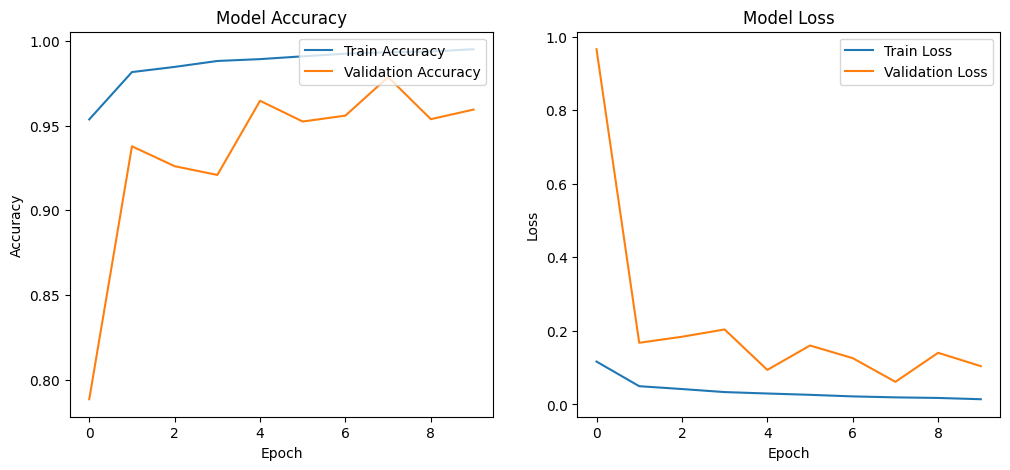

In [18]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_ft.history['accuracy'], label='Train Accuracy')
plt.plot(history_ft.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_ft.history['loss'], label='Train Loss')
plt.plot(history_ft.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

## Evaluate the Model on the Test Set (Before Restoration)

In [19]:
# Evaluate the model (which may be overfitted) on the test set
test_loss, test_acc = model_ft.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 175s 558ms/step - accuracy: 0.9736 - loss: 0.0854
Test Loss: 0.060867808759212494
Test Accuracy: 0.980650007724762


## Restore Best Weights and Re-Evaluate

In [20]:
# Create a new model instance and load the best weights saved during training
model = get_model(input_shape)
model.load_weights('/kaggle/working/model_cp.weights.h5')  # Adjust the path as necessary

# Evaluate the restored model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss after restoring best weights:", test_loss)
print("Test Accuracy after restoring best weights:", test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 738 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 214ms/step - accuracy: 0.9736 - loss: 0.0854
Test Loss after restoring best weights: 0.060867808759212494
Test Accuracy after restoring best weights: 0.980650007724762


## Qualitative Results: Real Image Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


Text(0.5, 1.0, 'This image is 0.00% Fake and 100.00% Real.')

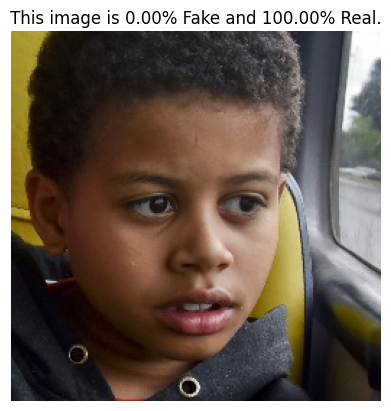

In [21]:
# Load a real image example and predict
test_image = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/deep-learning-project/real_vs_fake/real-vs-fake/test/real/00343.jpg',
    target_size=(256, 256, 3)
)
plt.imshow(test_image)
plt.axis('off')

test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image_arr, axis=0)
test_image_arr = test_image_arr / 255.

result = model.predict(test_image_arr)
plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")


## Qualitative Results: Fake Image Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Text(0.5, 1.0, 'This image is 99.83% Fake and 0.17% Real.')

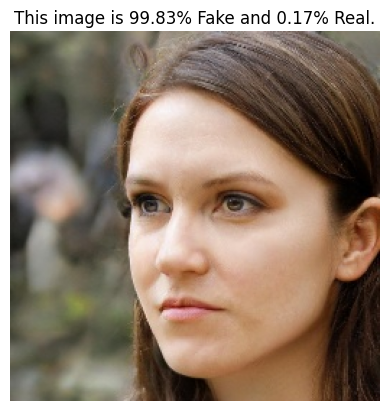

In [22]:
# Load a fake image example and predict
test_image = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/deep-learning-project/real_vs_fake/real-vs-fake/test/fake/00V5CZZSSO.jpg',
    target_size=(256, 256, 3)
)
plt.imshow(test_image)
plt.axis('off')

test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image_arr, axis=0)
test_image_arr = test_image_arr / 255.

result = model.predict(test_image_arr)
plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

## Quantitative Results: Confusion Matrix and ROC Curve

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 228ms/step


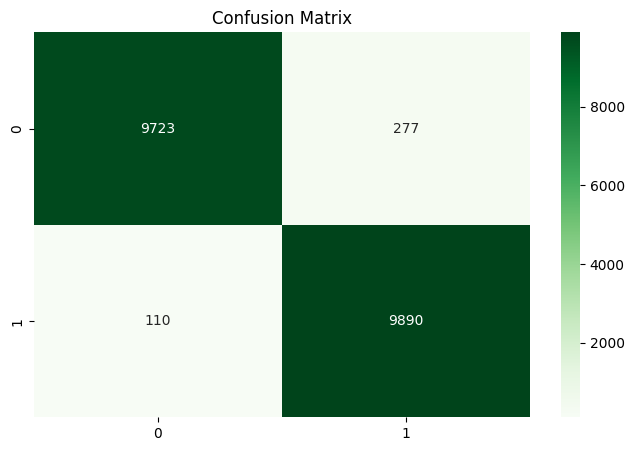

Test Accuracy (using confusion matrix): 0.98065


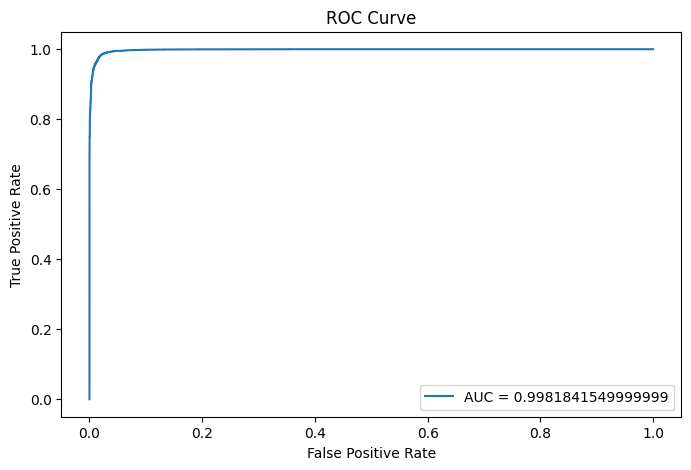

In [23]:
# Generate predictions for the test set
predicted_labels = model.predict(test_ds)
true_labels = test_ds.classes

# Plot the confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()),
            annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix")
plt.show()

print("Test Accuracy (using confusion matrix):", metrics.accuracy_score(true_labels, predicted_labels.round()))

# Compute and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(true_labels, predicted_labels)
auc = metrics.roc_auc_score(true_labels, predicted_labels)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label="AUC = " + str(auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc=4)
plt.show()

## Save Final Model

In [25]:
# Save the final trained model to disk
model.save('deepfake_detection_model.h5')
print("Final model saved successfully!")

Final model saved successfully!
